## Setup

### Imports

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import pandas as pd
from itertools import product
import IPython.display as ipd
import matplotlib.pyplot as plt
import tqdm

from src.ftm import constants as FTM_constants
from src.knn import KnnG
from src.phi import MSS_ref_factory



### Create Parameters Dataset

In [2]:
# Create DataFrame and write it to a CSV file for later use

def create_DF(bounds, subdiv, path):
    
    #Linspace of every parameters of size k
    Dbase = np.zeros((subdiv,5))
    for i in range(5):
        Dbase[:,i] = np.linspace(bounds[1][i][0],bounds[1][i][1],subdiv)
    baseDF = pd.DataFrame(data=Dbase,columns=bounds[0])

    #Product of the linspaces to get all the possible combinations (size subdiv**5, will take time)
    D = list(product(baseDF['omega'],baseDF['tau'],baseDF['p'],baseDF['d'],baseDF['alpha']))
    DF = pd.DataFrame(data=D,columns=bounds[0])

    DF.to_csv(path)
    
    return DF


In [3]:
# Boundaries

bounds = [['omega', 'tau', 'p', 'd', 'alpha'],
 [(2.4, 3.8),
  (0.4, 3),
  (-5, -0.7),
  (-5, -0.5),
  (10e-05, 1)]]

# Only run this to recreate the parameters CSV, this can take a long time to finish depending on the subdivision

create_DF(bounds=bounds, subdiv=2, path='data/default_parameters.csv')


,omega,tau,p,d,alpha
0,2.4,0.4,-5.0,-5.0,0.0001
1,2.4,0.4,-5.0,-5.0,1.0000
2,2.4,0.4,-5.0,-0.5,0.0001
3,2.4,0.4,-5.0,-0.5,1.0000
4,2.4,0.4,-0.7,-5.0,0.0001
5,2.4,0.4,-0.7,-5.0,1.0000
6,2.4,0.4,-0.7,-0.5,0.0001
7,2.4,0.4,-0.7,-0.5,1.0000
8,2.4,3.0,-5.0,-5.0,0.0001
9,2.4,3.0,-5.0,-5.0,1.0000


## Main

In [4]:
# Setting the parameters
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True
k = 10
total_iter = int(DF.size(dim=0)**2)

# Main job
print('computing the knn (P-loss)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_ploss = KnnG(DF,k,MSS_ref_factory,logscale,'P-loss',update_pb=pbar.update)

print('computing the knn (Perceptual-KNN)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_perceptualknn = KnnG(DF,k,MSS_ref_factory,logscale,'Perceptual-KNN',update_pb=pbar.update)

print('computing the knn (Bruteforce)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_bruteforce = KnnG(DF,k,MSS_ref_factory,logscale,'Bruteforce',update_pb=pbar.update)

computing the knn (P-loss)


100%|██████████| 1024/1024 [00:00<00:00, 9782.25it/s]


computing the knn (Perceptual-KNN)


100%|██████████| 1024/1024 [00:01<00:00, 786.59it/s]


computing the knn (Bruteforce)


100%|██████████| 1024/1024 [00:11<00:00, 88.81it/s]


In [5]:
from src.distances import distance_factory
from src.jacobian import M_factory
from src.phi import MSS_ref_factory
from src.ftm import rectangular_drum
from src.ftm import constants as FTM_constants
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True

theta_r = DF[0,:]
theta_c = DF[2,:]

x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = MSS_ref_factory(x_r)

M = M_factory(logscale,phi)
M_r = M(theta_r)

M_r

tensor([[ 2.8505e+21,  2.8058e+19,  8.7101e+17,  1.8891e+20, -8.2421e+23],
        [ 2.8058e+19,  2.7619e+17,  8.5737e+15,  1.8595e+18, -8.1131e+21],
        [ 8.7101e+17,  8.5737e+15,  2.6615e+14,  5.7725e+16, -2.5185e+20],
        [ 1.8891e+20,  1.8595e+18,  5.7725e+16,  1.2520e+19, -5.4624e+22],
        [-8.2421e+23, -8.1131e+21, -2.5185e+20, -5.4624e+22,  2.3832e+26]],
       device='cuda:0', dtype=torch.float64)

# Method characterization

In [6]:
from src.distances import distance_factory
from src.phi import MSS_ref_factory
from src.ftm import rectangular_drum
n = T_knn_bruteforce.size(dim=0)


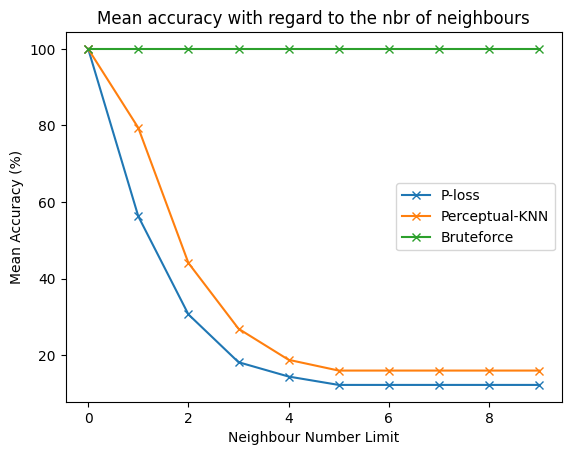

In [7]:
LMBAcc = []
LMPKNNAcc = []
LMPAcc = []

for klim in range(k):

    MeanBruteforceAcc = 0.
    MeanPerceptualKNNAcc = 0.
    MeanPlossAcc = 0.

    for i_ref in range(n):
        BruteforceAcc = 0
        PerceptualKNNAcc = 0
        PlossAcc = 0

        for i_knn in range(k):
            BruteforceAcc += (T_knn_bruteforce[i_ref,i_knn,:klim] == T_knn_bruteforce[i_ref,i_knn,:klim]).all()
            PerceptualKNNAcc += (T_knn_perceptualknn[i_ref,i_knn,:klim] == T_knn_bruteforce[i_ref,i_knn,:klim]).all()
            PlossAcc += (T_knn_ploss[i_ref,i_knn,:klim] == T_knn_bruteforce[i_ref,i_knn,:klim]).all()

        MeanBruteforceAcc += 100*BruteforceAcc/k
        MeanPerceptualKNNAcc += 100*PerceptualKNNAcc/k
        MeanPlossAcc += 100*PlossAcc/k

    MeanBruteforceAcc /= n
    MeanPerceptualKNNAcc /= n
    MeanPlossAcc /= n

    LMBAcc.append(MeanBruteforceAcc.cpu())
    LMPKNNAcc.append(MeanPerceptualKNNAcc.cpu())
    LMPAcc.append(MeanPlossAcc.cpu())

plt.figure(0)
x = np.linspace(0,k-1,k)
plt.plot(x,LMPAcc,'-x',x,LMPKNNAcc,'-x',x,LMBAcc,'-x')
plt.xlabel("Neighbour Number Limit")
plt.ylabel("Mean Accuracy (%)")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("Mean accuracy with regard to the nbr of neighbours")
plt.show()

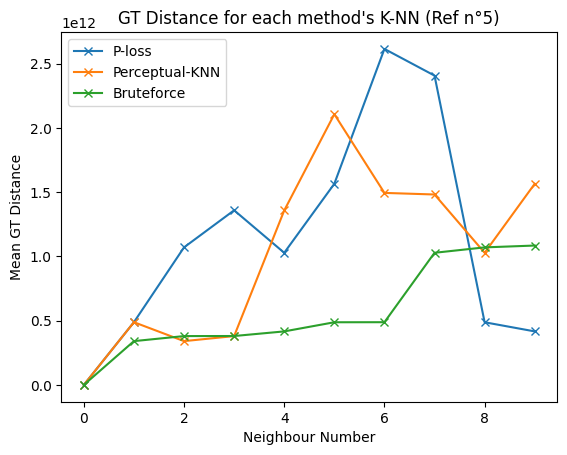

In [9]:
i_ref = 5

MeanDploss = np.zeros((1,k))
MeanDperceptualknn = np.zeros((1,k))
MeanDbruteforce = np.zeros((1,k))

theta_r = T_knn_bruteforce[i_ref,0,:]
x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = MSS_ref_factory(x_r)
S_r = phi(x_r)

dist = distance_factory("Bruteforce",phi,logscale)

Dploss = []
Dperceptualknn = []
Dbruteforce = []

for i in range(k):
    Dploss.append(dist(T_knn_ploss[i_ref,i,:],S_r).item())
    Dperceptualknn.append(dist(T_knn_perceptualknn[i_ref,i,:],S_r).item())
    Dbruteforce.append(dist(T_knn_bruteforce[i_ref,i,:],S_r).item())

plt.figure(1)
x = np.linspace(0,len(Dploss)-1,len(Dploss))
plt.plot(x,Dploss,'-x',x,Dperceptualknn,'-x',x,Dbruteforce,'-x')
plt.xlabel("Neighbour Number")
plt.ylabel("Mean GT Distance")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("GT Distance for each method's K-NN (Ref n°"+str(i_ref)+")")
plt.show()